In [1]:
import astropy
import astroquery
import matplotlib.pyplot as plt
import pandas
import ipywidgets as widgets
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time, TimeDelta
from datetime import datetime
from ipywidgets import Layout, Button, Box, VBox, HBox
from IPython.display import display, clear_output
from astroplan import FixedTarget, Observer
from astroplan.plots import plot_airmass, plot_finder_image, plot_sky
from astroquery.simbad import Simbad
import astropy.coordinates as coordinates
import warnings
warnings.filterwarnings("ignore", message="Numerical value without unit or explicit format passed to TimeDelta, assuming days")

In [2]:
Simbad.add_votable_fields("U", "V", "B")

In [3]:
Name = "Target name**"
RA = "RA**"
Dec = "Dec**"

In [4]:
from astropy.utils import iers
iers.conf.IERS_A_URL = 'ftp://cddis.gsfc.nasa.gov/pub/products/iers/finals2000A.all'
iers.conf.IERS_A_URL_MIRROR = 'https://datacenter.iers.org/data/9/finals2000A.all'
from astroplan import download_IERS_A
download_IERS_A()

In [5]:
sheet = pandas.read_csv("TargetSubmissionTemplate.csv")         # Read in targets. 
                                                                # Either ppl will have to make sure the file name is above (hardcoded), OR
                                                                # we might need to glob. FIXME OR we can prompt for name of csv? w/ default ^
sheet = sheet[sheet[RA].str.contains("nan") == False]           # Gets rid of blank rows



vega_name = sheet[Name][1];
vega_RA = sheet[RA][1];
vega_Dec = sheet[Dec][1];
vega_coord = SkyCoord(ra=vega_RA, dec=vega_Dec, unit=(u.hourangle, u.deg), frame='icrs')
vega_target = FixedTarget(vega_coord, name="Vega")
# and so forth... (loop)
print(vega_RA)

# Ref used: https://www.geeksforgeeks.org/how-to-drop-rows-that-contain-a-specific-string-in-pandas/

# Putting the above code into loop:
i = 2



18 36 56.3364


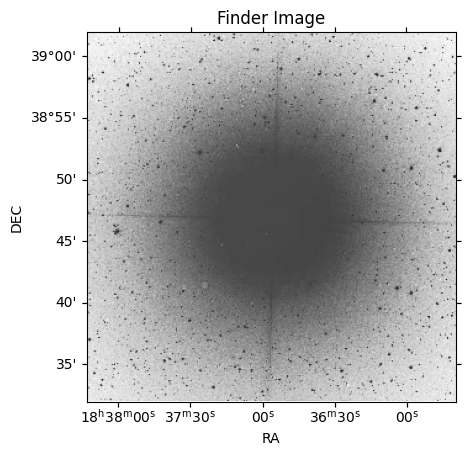

In [6]:
# Define observer (RHO)
RHO = Observer(
    location=coordinates.EarthLocation(lat=29.4001, lon=-82.5862*u.deg, height=23*u.m),
    timezone='US/Eastern',
    name='Rosemary Hill Observatory'
)
ax, hdu = plot_finder_image(vega_target, fov_radius=15*u.arcmin)
ax.set_title('Finder Image');

In [7]:
result_table = Simbad.query_object("vega")
print(result_table)

 main_id         ra              dec       ...          B           matched_id
                deg              deg       ...                                
--------- ---------------- --------------- ... -------------------- ----------
* alf Lyr 279.234734787025 38.783688956244 ... 0.029999999329447746  NAME Vega


In [8]:
now = Time.now()
now.to_datetime(timezone=RHO.timezone).isoformat()
def eastern(time):
    est = time.to_datetime(timezone=RHO.timezone)
    
    return est.strftime('%H:%M:%S')

In [9]:
(eastern(RHO.target_rise_time(time=now, target=vega_target)),
 eastern(RHO.target_set_time(time=now, target=vega_target)))

('15:36:43', '07:13:42')

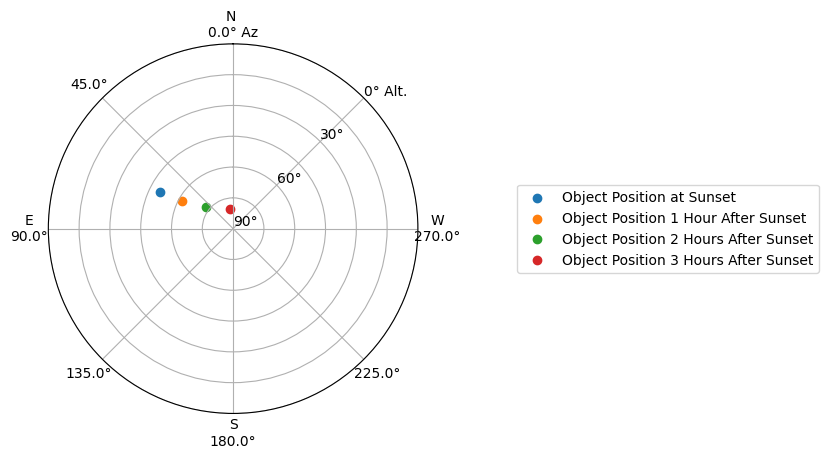

In [10]:
sunset_times = [RHO.sun_set_time(now), RHO.sun_set_time(now) + 1*u.hour, 
                RHO.sun_set_time(now) + 2*u.hr, RHO.sun_set_time(now) + 3*u.hr]
sunset_times_titles = ["Object Position at Sunset", "Object Position 1 Hour After Sunset", 
                      "Object Position 2 Hours After Sunset", "Object Position 3 Hours After Sunset"]
            
for i in range(len(sunset_times_titles)):
    style_label = {"label" : sunset_times_titles[i]}
    plot_sky(target=vega_target, observer=RHO, time=sunset_times[i], style_kwargs=style_label)
plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5))

Name: * alf Lyr
Coordinates: 18h36m56.33, 38d47m01.28
Magnitude V: 0.03
Rises: 15:36:43 EST
Sets: 07:13:42 EST


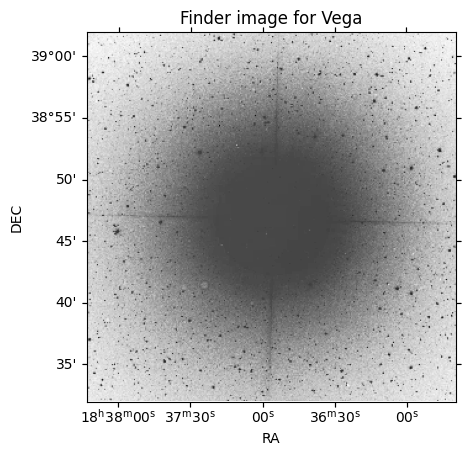

In [61]:
# Calibration stars
style = {'description_width': 'initial'}
calib_stars = widgets.Dropdown(
    options=['Capella', 'Sirius', 'Arcturus', 'Vega', 'Deneb', 
             'Altair', 'Spica', 'Polaris', 'Mirfak', 'Aldebaran', 
             'Schedar', 'Procyon', 'Regulus', 'Dubhe', 'Antares', 'Fomalhaut'],
    value=None,
    description='Calibration star:',
    style=style
)
output = widgets.Output()


def dropdown_calib_star_eventhandler(star):
    clear_output(wait=True)
    result_table = Simbad.query_object(calib_stars.value)[["main_id", "ra", "dec", "V"]]
    coords = SkyCoord(ra=result_table["ra"], dec=result_table["dec"])
    info = [result_table["main_id"][0], coords.to_string('hmsdms'), result_table["V"][0]]
    curr_target = FixedTarget(coords, name=calib_stars.value)

    rise_set = [eastern(RHO.target_rise_time(time=now, target=curr_target)), eastern(RHO.target_set_time(time=now, target=curr_target))]
    
    display(dis)
    print("Name: " + info[0])
    print("Coordinates: " + str(info[1])[2:13] +", " + str(info[1])[22:33])         # Cutting off the long decimal points for readibility - we don't need to be THAT precise for calib stars
    print("Magnitude V: " + str(round(float(info[2]), 5)))
    print("Rises: " + rise_set[0] + " EST")
    print("Sets: " + rise_set[1] + " EST")     
    
    ax, hdu = plot_finder_image(curr_target, fov_radius=15*u.arcmin)
    title = "Finder image for " + str(calib_stars.value)
    ax.set_title(title); 
    
calib_stars.observe(dropdown_calib_star_eventhandler, names='value')
dis = widgets.HBox([calib_stars])
display(dis)

# Used https://towardsdatascience.com/interactive-data-analysis-with-dropdown-menu-ipywidgets-and-plotly-in-jupyter-notebook-591a84a81b22 
# for reference in doing the dropdown selection


In [11]:
# # Define observer (RHO)
# RHO = Observer(
#     location=coordinates.EarthLocation(lat=29.4001, lon=-82.5862*u.deg, height=23*u.m),
#     timezone='US/Eastern',
#     name='Rosemary Hill Observatory'
# )

# # Initialize global variables
# object_target = desired_date = fov_radius = None
# style = {'description_width': 'initial'}


# # Define widgets for RA/Dec input
# ra_descs = ["RA Hours:", "RA Minutes:", "RA Seconds:"]
# ra_auto = [widgets.FloatText(description=ra_descs[i], layout=Layout(flex='3 1 auto')) for i in range(len(ra_descs))]

# dec_descs = ["Dec Degrees:", "Dec Minutes:", "Dec Seconds:"]
# dec_auto = [widgets.FloatText(description=dec_descs[i], layout=Layout(flex='3 1 auto')) for i in range(len(dec_descs))]

# name_widget = widgets.Text(description="Object Name:")

# display(HBox(ra_auto), HBox(dec_auto), (name_widget))


# # Function to convert RA/Dec widget values to degrees and create FixedTarget
# def handle_submit_ra_dec(sender):
#     ra_h, ra_m, ra_s = [ra_auto[i].value for i in range(len(ra_auto))]
#     dec_d, dec_m, dec_s = [dec_auto[i].value for i in range(len(dec_auto))]
#     ra_deg = (ra_h + ra_m / 60.0 + ra_s / 3600.0) * 15.0  # RA in degrees
#     dec_deg = dec_d + dec_m / 60.0 + dec_s / 3600.0       # Dec in degrees
#     if dec_d < 0:
#             dec_deg = -dec_deg
    
#     coords = [ra_m, ra_s, dec_m, dec_s]
#     check = check_valid(ra_h, dec_d, ra_deg, dec_deg, coords)       # Including all of these vars might be unnecessary, I just don't want to think abt coords more than I have to - Pae

#     if check:
#         try:
#             global object_target
#             target_name = name_widget.value.strip()
#             object_coord = SkyCoord(ra=ra_deg * u.deg, dec=dec_deg * u.deg, frame='icrs')
#             object_target = FixedTarget(coord=object_coord, name=target_name)

#             print(f"Created Target: {object_target}")
#         except:
#             print("Target creation failed - please check input coordinates.")       # Just to double make sure things don't break lol - Pae
#     else:
#         print("Target creation failed - please check input coordinates.")

# submit_ra_dec_button = widgets.Button(description="Submit RA/Dec")
# submit_ra_dec_button.on_click(handle_submit_ra_dec)
# display(submit_ra_dec_button)

# # Ensure input coords are valid
# def check_valid(ra_h, dec_d, ra_deg, dec_deg, coords):
#     if ra_h < 0 or ra_h > 24 or abs(ra_deg) > 360:        # Check RA
#         return False
#     if abs(dec_d) > 90 or abs(dec_deg) > 90:              # Check Dec
#         return False
#     if any(val > 60 for val in coords):     # Check arcmins and arcsecs to be smaller than 60
#         return False
#     else:
#         return True


# # Define widgets for Date input
# time_descs = ["Year:", "Month:", "Day:"]
# time_auto = [widgets.IntText(description=time_descs[i]) for i in range(len(time_descs))]
# display(HBox(time_auto))

# # Function to handle Date submission
# def handle_submit_date(sender):
#     year, month, day = [time_auto[i].value for i in range(len(time_auto))]
#     try:
#         global desired_date 
#         desired_date = Time(datetime(year, month, day), format='datetime', scale='utc')
#         print(f"Desired Date: {desired_date}")
#     except:
#         print("Error. Please check input values and try again.")

# submit_date_button = widgets.Button(description="Submit Date")
# submit_date_button.on_click(handle_submit_date)
# display(submit_date_button)


# # Define widgets for FOV input
# fov_radius_widget = widgets.IntText(description="FOV in arcminutes:", style=style)
# display(fov_radius_widget)

# # Function to handle FOV submission (for Finder Image)
# def handle_submit_fov(sender):
#     global fov_radius
#     fov_radius = fov_radius_widget.value * u.arcmin
#     print(f"FOV Radius: {fov_radius}")

# submit_fov_button = widgets.Button(description="Submit FOV")
# submit_fov_button.on_click(handle_submit_fov)
# display(submit_fov_button)


# # Function to handle Airmass plotting
# def handle_plot_airmass(sender):
#     global object_target, desired_date
#     if object_target is not None and desired_date is not None:
#         try:
#             time_range = desired_date + TimeDelta(range(0, 24*60, 10)*u.minute)
#             fig, ax = plt.subplots(figsize=(8, 6))
#             plot_airmass(object_target, observer=RHO, time=time_range, brightness_shading=True, ax=ax)
#             ax.set_title("Airmass Plot")
#             if object_target.name != "":
#                 plt.legend(loc='best')
#         except:
#             print("Error. Please check input values and try again.")
#     else:
#         print("Please enter RA/Dec and Date first.")

# plot_airmass_button = widgets.Button(description="Plot Airmass")
# plot_airmass_button.on_click(handle_plot_airmass)
# display(plot_airmass_button)


# # Function to handle Finder Image plotting
# def handle_plot_finder_image(sender):
#     global object_target, fov_radius
#     if object_target is not None and fov_radius is not None:
#         try:
#             fig, ax = plt.subplots(figsize=(8, 6))
#             ax, hdu = plot_finder_image(object_target, survey='DSS', fov_radius=fov_radius, ax=ax)
#             ax.set_title('Finder Image')
#         except:
#             print("Error. Please check input values and try again.")
#     else:
#         print("Please enter RA/Dec and FOV first.")

# plot_finder_button = widgets.Button(description="Plot Finder Image")
# plot_finder_button.on_click(handle_plot_finder_image)
# display(plot_finder_button)


# # Function to calculate and plot sky positions at sunset and subsequent times
# def handle_plot_sky_positions(sender):
#     global object_target, desired_date
#     if object_target is not None and desired_date is not None:
#         try:
#             sunset_times = [RHO.sun_set_time(desired_date), RHO.sun_set_time(desired_date) + 1*u.hour, 
#                             RHO.sun_set_time(desired_date) + 2*u.hr, RHO.sun_set_time(desired_date) + 3*u.hr]
#             sunset_times_titles = ["Object Position at Sunset", "Object Position 1 Hour After Sunset", 
#                                    "Object Position 2 Hours After Sunset", "Object Position 3 Hours After Sunset"]
            
#             for i in range(len(sunset_times_titles)):
#                 style_label = {"label" : sunset_times_titles[i]}
#                 plot_sky(target=object_target, observer=RHO, time=sunset_times[i], style_kwargs=style_label)
#             plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5))
#         except:
#             print("Error. Please check input values and try again.")
#     else:
#         print("Please enter RA/Dec and Date first.")

# plot_sky_positions_button = widgets.Button(description="Plot Sky Positions")
# plot_sky_positions_button.on_click(handle_plot_sky_positions)
# display(plot_sky_positions_button)

In [12]:
# SO. Need to merge the first code block (excl. imports) and the second. Might want to do this in uh, a way. that. observers can choose, like out
# of an
# array of objects to observe, then press relating button to that object>? But this all comes After the step where we prioritize shit and choose
# what will be observed this night out of what was given to us (presumably the full sheet from drive but not necessarily). 
# see Triana code assignment for determining timing as in, what is Up during given night.


In [13]:
# Authors: Triana Almeyda, Cassidy Camera, Pae Swanson